In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import geopandas as gpd

from sklearn.cluster import KMeans
from sklearn.preprocessing import PowerTransformer

## Useful functions

In [2]:
#preprocess the raw climate data in a dataframe
def init_df(state_name):
    ds_init = xr.open_dataset(f'../../Data/ClimateData/{state_name}.nc')
    df_init = ds_init.to_dataframe()
    df_init.reset_index(inplace=True)
    df_init = df_init.drop(columns = ['longitude', 'latitude'])

    return df_init

# initialise array in which we evaluate :
# the mean and variance of each category for each year,
# the mean and variance over all the years for the to stats above.
def init_arrays(df_init):
    df_init['time'] = df_init['time'].astype('datetime64')
    df_init['ssr'] = df_init['ssr']*1e-7

    mean_years_init = df_init.groupby(df_init.time.dt.to_period("Y")).mean()
    var_years_init = df_init.groupby(df_init.time.dt.to_period("Y")).var()

    mean_mean_arr = mean_years_init.mean().to_numpy().reshape(1,7)
    mean_var_arr = mean_years_init.var().to_numpy().reshape(1,7)
    var_mean_arr = var_years_init.mean().to_numpy().reshape(1,7)
    var_var_arr = var_years_init.var().to_numpy().reshape(1,7)

    return(mean_mean_arr, mean_var_arr, var_mean_arr, var_var_arr)

In [3]:
# complete the array with all the states and turn it into a dataframe
def total_dataframe(states_names, state_init, mean_mean_arr_init, mean_var_arr_init, var_mean_arr_init, var_var_arr_init, season):
    """season vaut 0 si on ne prend pas les saisons en compte, 1 pour rabi et 2 pour kharif"""
    mean_mean_arr = mean_mean_arr_init.copy()
    mean_var_arr = mean_var_arr_init.copy()
    var_mean_arr = var_mean_arr_init.copy()
    var_var_arr = var_var_arr_init.copy()

    for state in states_names :
        if state != state_init :
            df_state = init_df(state)

            if season == 1:
                df_state = split_seasons_df(df_state)[0]
            elif season == 2:
                df_state = split_seasons_df(df_state)[1]

            df_state['time'] = df_state['time'].astype('datetime64')
            df_state['ssr'] = df_state['ssr']*1e-7

            mean_years_state = df_state.groupby(df_state.time.dt.to_period("Y")).mean()
            var_years_state = df_state.groupby(df_state.time.dt.to_period("Y")).var()

            mean_mean_arr = np.concatenate((mean_mean_arr, mean_years_state.mean().to_numpy().reshape(1,7)), axis=0)
            mean_var_arr = np.concatenate((mean_var_arr, var_years_state.mean().to_numpy().reshape(1,7)), axis=0)
            var_mean_arr = np.concatenate((var_mean_arr, mean_years_state.var().to_numpy().reshape(1,7)), axis=0)
            var_var_arr = np.concatenate((var_var_arr, var_years_state.var().to_numpy().reshape(1,7)), axis=0)
            
    tot_arr = np.concatenate((mean_mean_arr, mean_var_arr, var_mean_arr, var_var_arr), axis=1)
    tot_df = pd.DataFrame(tot_arr)
    tot_df.insert(0,'state',states_names)
    tot_df['state'] = tot_df['state'].replace(to_replace='Andhra_Pradesh', value='Andhra Pradesh')
    tot_df['state'] = tot_df['state'].replace(to_replace='Madhya', value='Madhya Pradesh')
    tot_df['state'] = tot_df['state'].replace(to_replace='Tamil_Nadu', value='Tamil Nadu')
    tot_df['state'] = tot_df['state'].replace(to_replace='Uttar_Pradesh', value='Uttar Pradesh')
    tot_df['state'] = tot_df['state'].replace(to_replace='West_Bengal', value='West Bengal')
    
    return tot_df

In [4]:
# plot an elbow method to determine the optimal number of clusters over the data
def elbow(df):
    losses = []
    X = [1,2,3,4,5,6,7,8,9]
    for i in range(1,10) :
        kmeans = KMeans(n_clusters=i).fit(df)
        kmeans_loss = kmeans.inertia_
        losses.append(kmeans_loss)
    plt.plot(X,losses)
    plt.show

In [5]:
# plot the clusters
def plot_climate_cluster(map_path, plot_data, color_map='RdYlGn'):
    map_gdf = gpd.read_file(map_path)
    merged = map_gdf.set_index('NAME_1').join(plot_data.set_index('state'))

    fig, ax = plt.subplots(1, figsize=(12, 12))
    ax.axis('off')
    ax.set_title('Clustering of the states according to their climate data',
                fontdict={'fontsize': '15', 'fontweight' : '3'})
    fig = merged.plot(column='cluster', cmap=color_map, linewidth=0.5, ax=ax, edgecolor='0.2', categorical=True, legend=True)

In [6]:
# Split a dataframe according to the dates in order to have one dataframe for Rabi and one for Kharif
def split_seasons_df(df):
    time_arr = df['time'].to_numpy()
    months = time_arr.astype('datetime64[M]').astype(int) % 12 + 1
    months_df = pd.DataFrame(months, columns=['month']) 

    kharif_months = [6,7,8,9,10]
    rabi_months = [1,2,3,4,5,11,12]

    df['month'] = months_df['month']
    df_rabi = df[df['month'].isin(rabi_months)]
    df_kharif = df[df['month'].isin(kharif_months)]
    df_rabi = df_rabi.drop(columns = ['month'])
    df_kharif = df_kharif.drop(columns = ['month'])

    return df_rabi, df_kharif

## Climate data download

We have data on all states in India. The data can be found on the website copernicus.eu

The data correspond to : the soil temperature (level 1) : stl1, the volumetric soil water (layer 1) : swvl1, the surface net solar radiation : ssr, the evaporation from bare soil : evabs, the total precipitation and leaf area indices (high and low vegetation) : lai_hv and lai_lv.

We use Andhra Pradesh to initialise the array.

In [7]:
#map_path = "../../maps/ind_adm_shp/IND_adm2.shp"
map_path = "../../maps/gadm36_IND_shp/gadm36_IND_1.shp"

map_gdf = gpd.read_file(map_path)

In [8]:
state_init = "Andhra_Pradesh"
df_init = init_df(state_init)

mean_mean_arr, mean_var_arr, var_mean_arr, var_var_arr = init_arrays(df_init)

print(mean_mean_arr, mean_var_arr, var_mean_arr, var_var_arr)

[[-1.2290073e-03  1.1344796e+00  1.3304785e+00  3.0186871e+02
   1.5812786e+00  1.9782514e-03  2.4802735e-01]] [[3.2550329e-08 2.4534702e-11 6.9526640e-10 1.2383689e-01 1.5194430e-03
  1.5305652e-07 2.0385484e-04]] [[4.9914928e-07 1.3900558e+00 2.1276225e-01 1.4719764e+01 7.6612704e-02
  4.8026559e-06 8.3403084e-03]] [[1.6635232e-14 7.4556909e-11 7.4173472e-15 3.8357635e+00 1.3033778e-04
  4.0244492e-12 1.6736042e-06]]


Now we work on all the states.

We define to total dataframe.

In [9]:
states_names = ['Andhra_Pradesh', 'Bihar', 'Chhattisgarh', 'Gujarat', 'Haryana', 'Jharkhand', 'Karnataka', 'Madhya', 'Maharashtra', 'Odisha', 'Rajasthan', 'Tamil_Nadu', 'Telangana','Uttar_Pradesh', 'Uttarakhand', 'West_Bengal']

tot_df = total_dataframe(states_names, state_init, mean_mean_arr, mean_var_arr, var_mean_arr, var_var_arr, season=0)
tot_df.head()

,state,0,1,2,3,4,5,6,7,8,...,18,19,20,21,22,23,24,25,26,27
0,Andhra Pradesh,-0.001229,1.134480,1.330479,301.868713,1.581279,0.001978,0.248027,3.255033e-08,2.453470e-11,...,0.076613,4.802656e-06,0.008340,1.663523e-14,7.455691e-11,7.417347e-15,3.835763,0.000130,4.024449e-12,0.000002
1,Bihar,-0.001656,1.031843,1.498345,299.748993,1.482268,0.003560,0.249124,3.501319e-07,1.011809e+00,...,0.001287,2.403487e-07,0.000090,6.598254e-15,3.412872e-11,1.828802e-13,15.829796,0.000180,4.134414e-11,0.000001
2,Chhattisgarh,-0.001527,2.061678,2.172492,299.499023,1.537672,0.003853,0.248395,2.900420e-07,2.476165e-01,...,0.002349,4.174124e-07,0.000207,3.226073e-15,1.064060e-10,2.638507e-11,11.519966,0.000403,6.601789e-11,0.000002
3,Gujarat,-0.000732,1.268641,1.283179,302.195496,1.588620,0.001620,0.181327,5.716803e-07,9.651551e-01,...,0.001175,3.089622e-07,0.000198,1.583360e-14,4.293404e-11,2.244909e-11,5.337778,0.000231,4.204027e-11,0.000004
4,Haryana,-0.000934,0.029176,1.110758,300.030548,1.510832,0.001516,0.160569,7.001354e-07,5.446410e-02,...,0.001007,1.496486e-07,0.000252,2.322358e-14,3.552053e-16,2.476417e-08,39.287380,0.000144,4.850544e-12,0.000003


## K-means clustering

In [10]:
# We preprocess our data to use a K-means algorithm

full_data=tot_df.drop(columns = ['state'])

for c in full_data.columns:
    pt = PowerTransformer()
    full_data.loc[:, c] = pt.fit_transform(np.array(full_data[c]).reshape(-1, 1))

/Users/adrien/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/adrien/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:199: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


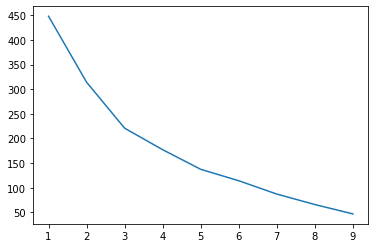

In [11]:
elbow(full_data)

In [12]:
kmeans = KMeans(n_clusters=5).fit(full_data)
kmeans_labels = kmeans.labels_
tot_df.insert(1,'cluster',kmeans_labels)

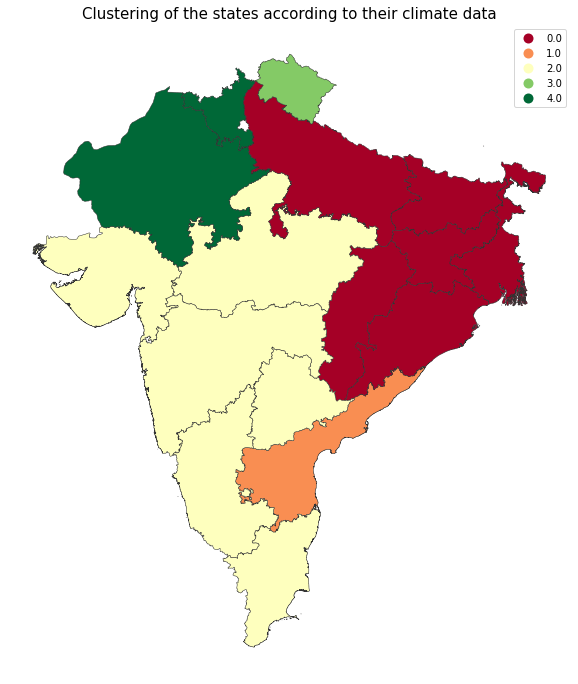

In [13]:
plot_climate_cluster(map_path, tot_df)

## Clustering according to the seasons

We split the dataset in two according to the season of the measures.

This allows us to have clusters according to the season.

In [14]:
state_init = "Andhra_Pradesh"
df_init = init_df(state_init)

df_init_rabi, df_init_kharif = split_seasons_df(df_init)

mean_mean_arr_rabi, mean_var_arr_rabi, var_mean_arr_rabi, var_var_arr_rabi = init_arrays(df_init_rabi)
mean_mean_arr_kharif, mean_var_arr_kharif, var_mean_arr_kharif, var_var_arr_kharif = init_arrays(df_init_kharif)

tot_rabi_df = total_dataframe(states_names, state_init, mean_mean_arr_rabi, mean_var_arr_rabi, var_mean_arr_rabi, var_var_arr_rabi, season=1)
tot_kharif_df = total_dataframe(states_names, state_init, mean_mean_arr_kharif, mean_var_arr_kharif, var_mean_arr_kharif, var_var_arr_kharif, season=2)

### Rabi clustering

/Users/adrien/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/adrien/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:199: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)
/Users/adrien/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: overflow encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/adrien/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: overflow encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/adrien/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: overflow encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/adrien/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: R

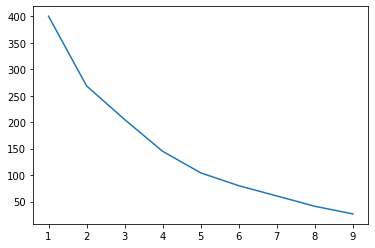

In [15]:
full_data_rabi=tot_rabi_df.drop(columns = ['state'])

for c in full_data_rabi.columns:
    pt = PowerTransformer()
    full_data_rabi.loc[:, c] = pt.fit_transform(np.array(full_data_rabi[c]).reshape(-1, 1))

elbow(full_data_rabi)

In [16]:
kmeans = KMeans(n_init=100, n_clusters=5).fit(full_data_rabi)
kmeans_labels_rabi = kmeans.labels_

if 'cluster' in tot_rabi_df.columns :
    tot_rabi_df = tot_rabi_df.drop(columns = ['cluster'])
tot_rabi_df.insert(1,'cluster',kmeans_labels_rabi)

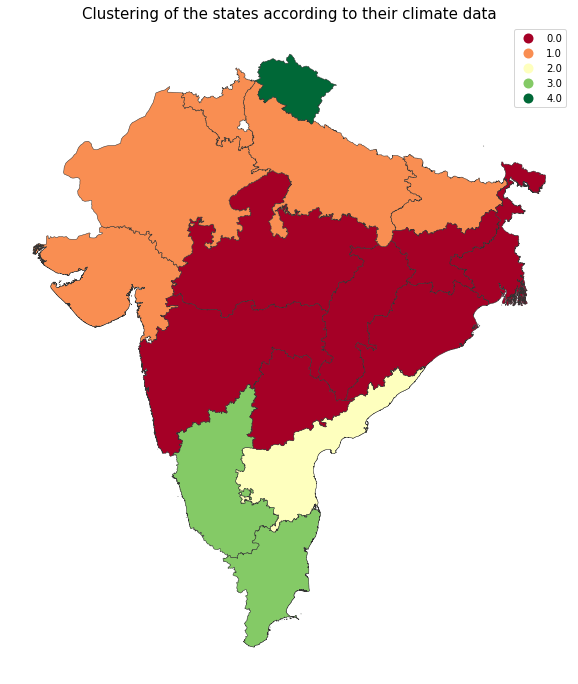

In [17]:
plot_climate_cluster(map_path, tot_rabi_df)

In [18]:
save_data = tot_rabi_df[['state', 'cluster']]
#save_data.to_csv('../../Outputs/Predictions/climate_clusters_rabi.csv')

### Kharif clustering

/Users/adrien/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/adrien/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: overflow encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/adrien/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:199: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)
/Users/adrien/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/adrien/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/adrien/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_dat

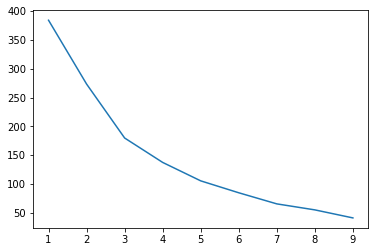

In [19]:
full_data_kharif=tot_kharif_df.drop(columns = ['state'])

for c in full_data_kharif.columns:
    pt = PowerTransformer()
    full_data_kharif.loc[:, c] = pt.fit_transform(np.array(full_data_kharif[c]).reshape(-1, 1))

elbow(full_data_kharif)

In [20]:
kmeans = KMeans(n_init=100, n_clusters=5).fit(full_data_kharif)
kmeans_labels_kharif = kmeans.labels_
if 'cluster' in tot_kharif_df.columns :
    tot_kharif_df = tot_kharif_df.drop(columns = ['cluster'])

tot_kharif_df.insert(1,'cluster',kmeans_labels_kharif)

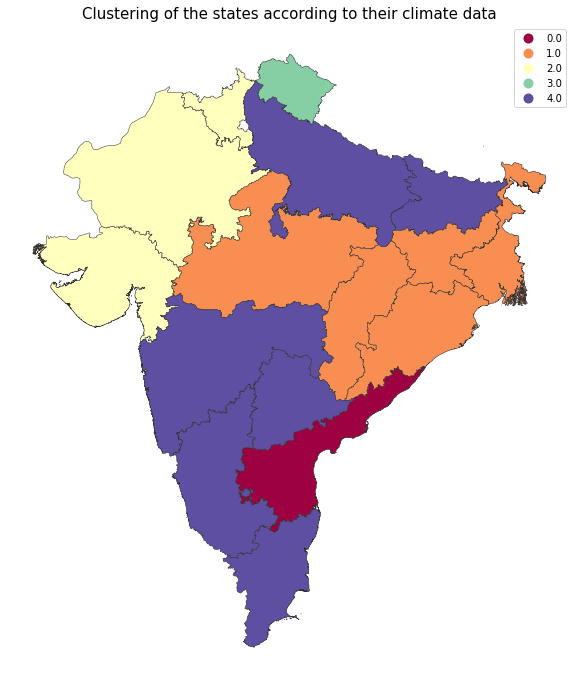

In [21]:
plot_climate_cluster(map_path, tot_kharif_df, color_map='Spectral')

In [22]:
save_data = tot_kharif_df[['state', 'cluster']]
#save_data.to_csv('../../Outputs/Predictions/climate_clusters_kharif.csv')